# Geopack & rechunk ET cells

In [1]:
import os
#os.environ['USE_PYGEOS'] = '1'

import dask
import pandas
import geopandas
import dask_geopandas
import dask.dataframe as ddf
from dask.distributed import LocalCluster, Client

#dask.config.set({'temporary_directory': '/home/jovyan/data/tmp/dask_tmp/'})

We set up a local cluster to run the rechunking on Dask:

In [2]:
client = Client(LocalCluster(n_workers=4))

In [5]:
client.shutdown()

Connect to the ET cells (under `form`) and other data:

In [3]:
form = dask_geopandas.read_parquet('form/')
function = ddf.read_parquet('function/')
ss = (
    ddf.read_parquet('signature_type/')
    .categorize('signature_type', index=False)
)

Join all and spatial shuffle with a repartition to only 100 partitions and write directly to disk:

---

**NOTE** - `form` and `function` are aligned so we can save some computation by concatenating them instead of joining by index. Before, we check that is the case:

In [4]:
%%time
ff_check = ddf.concat(
    [
        form.rename(columns={'hindex': 'hindex_form'}), 
        function.rename(columns={'hindex': 'hindex_function'}), 
    ], 
    axis='columns'
)
(ff_check['hindex_form'] != ff_check['hindex_function']).sum().compute()

CPU times: user 19 s, sys: 1.11 s, total: 20.1 s
Wall time: 49.9 s


0

---

## FF

Now we can proceed with the full operation:

In [4]:
gp_all = (
    ddf.concat(
        [
            form.rename(columns={'hindex': 'hindex_form'}), 
            function.rename(columns={'hindex': 'hindex_function'}), 
        ], 
        axis=1
    )
    .drop(columns=['hindex_form'])
    .repartition(npartitions=100)
    .rename(columns={'hindex_function': 'hindex'})
    .rename_geometry('geometry')
    #.spatial_shuffle(by='hilbert') # Requires a bigger machine
)

## Write out unpacked data

### Write geoms

Write ET cells to disk:

In [5]:
%%time
(
    gp_all
    [['geometry', 'hindex']]
    .to_parquet('../et_cells_geopack/et_cells')
)

/opt/conda/envs/gds/lib/python3.9/site-packages/dask_expr/_concat.py:146: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(
/opt/conda/envs/gds/lib/python3.9/site-packages/dask_expr/_concat.py:146: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(
/opt/conda/envs/gds/lib/python3.9/site-packages/dask_expr/_concat.py:146: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


### Write form

Write form to disk (as non-spatial table):

In [6]:
%%time
(
    gp_all
    [form.drop(columns='tessellation').columns]
    .to_parquet('../et_cells_geopack/form')
)

/opt/conda/envs/gds/lib/python3.9/site-packages/dask_expr/_concat.py:146: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(
/opt/conda/envs/gds/lib/python3.9/site-packages/dask_expr/_concat.py:146: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(
2024-08-08 12:29:48,444 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 9.80 GiB -- Worker memory limit: 15.62 GiB
2024-08-08 12:30:23,988 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 12

CPU times: user 1min, sys: 3.84 s, total: 1min 4s
Wall time: 3min 41s


### Write function

Write function to disk (as non-spatial table):

In [7]:
%%time
import pyarrow as pa

schema = {k: pa.float64() for k in function.columns}
schema["hindex"] = pa.string()
(
    gp_all
    [function.columns]
    .to_parquet('../et_cells_geopack/function', schema=schema)
)

/opt/conda/envs/gds/lib/python3.9/site-packages/dask_expr/_concat.py:146: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(
/opt/conda/envs/gds/lib/python3.9/site-packages/dask_expr/_concat.py:146: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


CPU times: user 54.8 s, sys: 3.34 s, total: 58.2 s
Wall time: 2min 36s


### Write SS

In [8]:
ids = ddf.read_parquet('../et_cells_geopack/et_cells/', columns=['hindex'])

Write signature types to disk:

In [9]:
%%time

ss_unique = ss.drop_duplicates().set_index('hindex')

(
    ids
    .join(ss_unique, on='hindex')
    .to_parquet('../et_cells_geopack/signature_type')
)

CPU times: user 1min 32s, sys: 6.14 s, total: 1min 38s
Wall time: 4min 3s


In [10]:
%%time

ss_check = ddf.concat(
    [
        (
            ddf.read_parquet('../et_cells_geopack/form/', columns=['hindex'])
            .rename(columns={'hindex': 'hindex_form'})
        ),
        ddf.read_parquet('../et_cells_geopack/signature_type/', columns=['hindex'])
    ],
    axis='columns'
)
(ss_check['hindex_form'] != ss_check['hindex']).sum().compute()

CPU times: user 2.17 s, sys: 80.7 ms, total: 2.25 s
Wall time: 2.88 s


0

## Spatial shuffle

- Re-pack spatially

In [3]:
%%time

shuffled = (
    dask_geopandas.read_parquet('../et_cells_geopack/et_cells')
    .spatial_shuffle(by='hilbert')
)

CPU times: user 24.8 s, sys: 1.86 s, total: 26.6 s
Wall time: 2min 38s


- Write out

In [4]:
shuffled.to_parquet('../et_cells_geopack/et_cells_geopacked')

## Spatial query example

We can perform efficient spatial queries combining `dask_geopandas` with `polars`.

In [6]:
import polars as pl

For example, we will pull out ET cells for the following area in Liverpool:

In [3]:
livs = """
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -2.997394358096301,
              53.41217462308123
            ],
            [
              -2.997394358096301,
              53.38294141317607
            ],
            [
              -2.9207670964097474,
              53.38294141317607
            ],
            [
              -2.9207670964097474,
              53.41217462308123
            ],
            [
              -2.997394358096301,
              53.41217462308123
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
"""
liv = geopandas.read_file(livs)
liv.explore()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/envs/gds/share/proj failed


First we pull out the geometries from the geopacked set:

In [4]:
%%time

geop = dask_geopandas.read_parquet('../et_cells_geopack/et_cells_geopacked/')
liv_etc = (
    geop
    [geop.within(liv.to_crs(geop.crs).geometry[0])]
).compute()

CPU times: user 2.89 s, sys: 233 ms, total: 3.12 s
Wall time: 16.3 s


And to extract non-spatial data, for example spatial signature type, we can then:

In [9]:
%%time

liv_ss = (
    pl.DataFrame(liv_etc[['hindex']])
    .lazy()
    .join(pl.scan_parquet('../et_cells_geopack/signature_type/'), on='hindex', how='left')
    .collect()
    .to_pandas()
)

CPU times: user 5.81 s, sys: 1.53 s, total: 7.34 s
Wall time: 695 ms


And merge (in this case in `pandas`, but if big or otherwise required, the join could happen in `polars`):

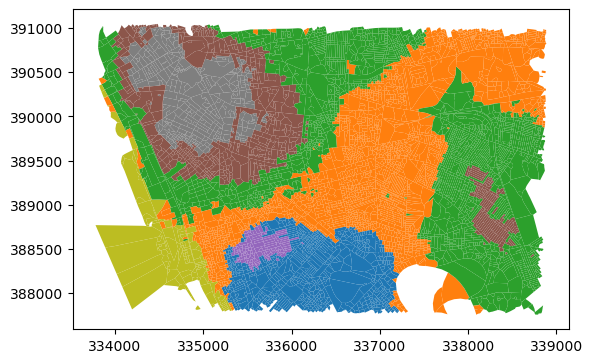

In [15]:
(
    liv_etc
    .join(liv_ss.set_index('hindex'), on='hindex')
    .plot(column='signature_type', categorical=True)
);